## Analyze A/B Test Results
## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.nunique() #290584 unique users

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
df.drop_duplicates('user_id').converted.mean() #proportion of unique users converted

0.1195695564793657

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('group == "control"').query('landing_page == "new_page"')['user_id'].count() + df.query('group == "treatment"').query('landing_page == "old_page"')['user_id'].count() #dont match 3893 times

3893

In [7]:
df.query('group == "control" and landing_page == "new_page" or group == "treatment" and landing_page == "old_page"') 

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
...,...,...,...,...,...
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0
294252,892498,2017-01-22 01:11:10.463211,treatment,old_page,0
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0


In [8]:
df.query('(group == "treatment" and landing_page != "new_page") or  (group != "treatment" and landing_page == "new_page")').shape[0]

3893

f. Do any of the rows have missing values?

In [9]:
df.info() #all rows have non-null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
drop1=df.query('group == "control" and landing_page == "new_page" or group == "treatment" and landing_page == "old_page"').index
#rows that will be dropped where control and old page and treatment and new page dont match

In [11]:
drop1.shape # the number of rows that will be removed

(3893,)

In [12]:
dfmissing=df.drop(drop1) #new dataframe after removing the rows above from our orginal dataframe

In [13]:
dfmissing.shape # number of rows remainig should be 294,478 less 3,893

(290585, 5)

In [14]:
df2 = df.query('group == "treatment" and landing_page =="new_page" or group == "control" and landing_page =="old_page"')
df2.head()  #new dataframe df2 where treatment matches new page and control matches with old page only

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [15]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [16]:
df2.nunique() #290584 unique user ids in df2

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

b. There is one **user_id** repeated in **df2**.  What is it?

In [17]:
df2[df2['user_id'].duplicated()]      

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat user_id?

In [18]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [19]:
df_dup=df2.query('user_id == 773192').duplicated(keep=False).index[0]    
df_dup

1899

d. Remove one of the rows with a duplicate user_id, but keep your dataframe as df2.

In [20]:
df2 = df2.drop(index = df_dup)

In [21]:
# Check that I removed one of the duplicates
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted


In [22]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [23]:
df2.shape # Check that I removed one of the duplicates

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [24]:
(len(df2[(df2['converted']==1)]))/len(df2['converted'])

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [25]:
df2.query('converted == True & group == "control"').count() /(df2.query('group=="control"').count())

user_id         0.120386
timestamp       0.120386
group           0.120386
landing_page    0.120386
converted       0.120386
dtype: float64

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [26]:
df2.query('converted == True & group == "treatment"').count() /(df2.query('group=="treatment"').count())

user_id         0.118808
timestamp       0.118808
group           0.118808
landing_page    0.118808
converted       0.118808
dtype: float64

d. What is the probability that an individual received the new page?

In [27]:
(df2.landing_page=="new_page").mean()   

0.5000619442226688

In [28]:
#creating dummies for the landing_page column
page_dummies = pd.get_dummies(df2['landing_page'])
df_page = df2.join(page_dummies)
df_page.head()

,user_id,timestamp,group,landing_page,converted,new_page,old_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


In [29]:
#dispaying the probability
df_page['new_page'].mean()

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

Based on the results above I do not believe that there is enough evidence to conclude that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**null hypothesis: P(new) <= P(old)**

**alternative hypothesis: P(new) > P(old)**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [30]:
p_new = df2['converted'].mean()
print(p_new)

0.11959708724499628


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [31]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [32]:
n_new = df2[df2.group=='treatment'].user_id.count()
print(n_new)

145310


d. What is $n_{old}$, the number of individuals in the control group?

In [33]:
n_old=df2[df2.group=='control'].user_id.count()
print(n_old)

145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [34]:
new_page_converted = np.random.choice([0,1], size=n_new, p=[(1- p_new), p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [35]:
old_page_converted = np.random.choice([0,1], size=n_old, p=[(1- p_old), p_old ])  
old_page_converted

array([0, 1, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [36]:
obs_diff = new_page_converted.mean() - old_page_converted.mean()
obs_diff

-0.0002979338717354757

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [37]:
p_diffs = []
for _ in range(10000):
    new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
    old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
    p_diffs = new_converted_simulation - old_converted_simulation
    p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

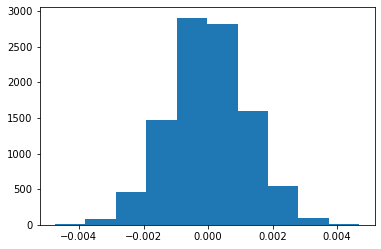

In [38]:
plt.hist(p_diffs); #normal distribution as expected

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [39]:
act_diff = df2[df2['group'] == 'treatment']['converted'].mean() - df2[df2['group'] == 'control']['converted'].mean()
act_diff

-0.0015782389853555567

In [40]:
(p_diffs > act_diff).mean()

0.9102

k. The value computed above shown as (p_diffs > act_diff).mean() is called the pvalue. A p-value is the probability of observing your statistic if the null hypothesis is true. Calculating p-value helps us to determine statistical significance of the observed difference. A small p-value (small probability) means it is unlikely the we will observe our statistic from the null, and more likely it came from the alternative.  As p-value is significantly bigger than the chosen significance level (5%) then we fail to reject the null hypothesis. 

For the new and old page, we see that old page provides a slightly better conversion rate than new page. So, we have to keep the old page.

The null hypothesis was that the difference in means would be equal or less than 0, and the alternative was the difference would be greater than 0. However, the difference is less than zero, and the p-value is very large. We do not have evidence to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [41]:
import statsmodels.api as sm

convert_old = sum((df2.group == 'control') & (df2.converted == 1))
convert_new =  sum((df2.group == 'treatment') & (df2.converted == 1))
n_old = sum(df2.group == 'control')
n_new = sum(df2.group == 'treatment')

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [42]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
z_score,p_value

(-1.3109241984234394, 0.9050583127590245)

In [43]:
from scipy.stats import norm
norm.cdf(z_score) #how significant our z_score is

0.09494168724097551

In [44]:
norm.ppf(1-(0.05)) #critical value of 95% confidence

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

With a very high p-value of .905 we fail to reject the Null which is the same result we obtained in parts j. and k.  We could not determine a significant difference in conversions between the control and treatment group.
Accordingly, a z-score of 1.31 is less than the critical value of 95% confidence level which is 1.65. Hence, we fail to reject the null hypothesis.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

We should use logistic regression, as we have just two types of outcomes.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [45]:
import statsmodels.api as sm

# Show data
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [46]:
# Create intercept for the regression model
df2['intercept'] = 1

In [47]:
# Create dummy variables
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [48]:
log_model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
model_result = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [49]:
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 20 Mar 2021   Pseudo R-squ.:               8.077e-06
Time:                        21:41:14   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

The p-value associated with the regression model is .19, which is higher than the significance level of .05.  

For hypothesis testing in part II:

$H0: Pnew - Pold <= 0$

$H1: Pnew - Pold > 0$

--> This is a one sided test


Hypothesis testing with the logistic model:

$H0: Pnew - Pold = 0$

$H1: Pnew - Pold ≠ 0$

--> This is a two sided test

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

Its a good idea to assess if you have chosen releveant factors into your model.  One way to do this is to ask an inhouse expert for important factors to consider.  Often times, senior collegues will have very important knowledge as to which factors to apply.  

A disadvantage to adding additional terms can be that the more factors that are applied, the more difficult the model could be to interpret, especially if the factor is categorical. You can always add factors, run the model and reevaluate the model by running it again after removal of the less significant factors from the model.

If the additional factors are not independent from each other, they might bias the coefficient and the p-value. Too many additional terms could weaken the model.   



g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [50]:
countries_df = pd.read_csv('./countries.csv')
df3 = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page
user_id,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1


In [51]:
# Create the necessary dummy variable
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])
df3.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0


In [52]:
log_model = sm.Logit(df3['converted'], df3[['intercept','ab_page','CA', 'UK']])
model_fit = log_model.fit() 
model_fit.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 20 Mar 2021   Pseudo R-squ.:               2.323e-05
Time:                        21:41:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

Interpretation: The countries CA and UK do not seem to have a significant impact on the conversion rate, p-value > alpha. US might have but we cannot separate US from the treatment group in this setup

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

I use the old page in US (US_old) as the baseline.

In [53]:
df4 = df3.copy()

In [54]:
df4['CA_old'] = df4['CA'] * df4['control']
df4['UK_old'] = df4['UK'] * df4['control']
df4['US_new'] = df4['US'] * df4['ab_page']
df4['CA_new'] = df4['CA'] * df4['ab_page']
df4['UK_new'] = df4['UK'] * df4['ab_page']

In [55]:
df4.head()

,country,timestamp,group,landing_page,converted,intercept,control,ab_page,CA,UK,US,CA_old,UK_old,US_new,CA_new,UK_new
user_id,,,,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0,0,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,0,1,0,0,0,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,0,1,0,0,0,0,0,1


In [56]:
log_m__page_country = sm.Logit(df4['converted'], df4[['intercept', 'CA_old', 'UK_old', 'US_new', 'CA_new', 'UK_new']])

In [57]:
results__page_country = log_m__page_country.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [58]:
results__page_country.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-03-20 21:41 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
CA_old       -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK_old       -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
US_new       -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA_new       -0.0850    0.0384    -2.2157  0.0267  -0.1601  -0.0098
UK_new        0.0051    0.0188     0.2710  0.7864  -0.0317   0.0419
==================================================================

"""

In [59]:
#CA_old
1/np.exp(-0.0175)

1.0176540221507617

In [60]:
#UK_old
1/np.exp(-0.0057)

1.0057162759095335

In [61]:
#US_new
1/np.exp(-0.0206)

1.020813644503746

In [62]:
#CA_new
1/np.exp(-0.0850)

1.0887170666983987

In [63]:
#UK_new
np.exp(0.0051)

1.005113027136717

Only the new page in Canada has a p-value under the significance-level of 0.05 (0.0267), where the conversion rate of the new page is 8.9% lower than the old page in US.  

Compared to the old page in US, all other combinations of page and country except the new page in UK seem to have lower conversion rates than the old page in US.  The new page in the UK has a similar conversion rate as the old page in the US.  However, since the p-values of these conversion rates are higher than our significance level of .05, the rates have no statistical significance.   

Based on all of the results above I would recommend keeping the old web page.  The results of our probabilty approach were inconclusive at best, with the old page converting users at a slightly higher rate than the new page.  The results of the one sided hypothesis test, and the two sided test using logistic regression modelling returned p values which were higher than the significance value of .05, which leads us to the conclusion of failing to reject the Null hypothesis, and keeping the old page.  

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [64]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

1